In [1]:
import numpy as np
from free_lie_algebra import *
import matplotlib.pyplot as plt

In [2]:
def chebyshev_T_polynomial(n):
    """Chebyshev polynomial of the first kind."""
    if n == 0:
        return {0: 1}
    elif n == 1:
        return {1: 1}
    else:
        T_prev = chebyshev_T_polynomial(n - 1)
        T_prev2 = chebyshev_T_polynomial(n - 2)
        T = {}

        for power, coeff in T_prev.items():
            T[power + 1] = T.get(power + 1, 0) + 2 * coeff

        for power, coeff in T_prev2.items():
            T[power] = T.get(power, 0) - coeff

        return T

def chebyshev_U_polynomial(n):
    """Chebyshev polynomial of the second kind."""
    if n == 0:
        return {0: 1}
    elif n == 1:
        return {1: 2}
    else:
        U_prev = chebyshev_U_polynomial(n - 1)
        U_prev2 = chebyshev_U_polynomial(n - 2)
        U = {}

        for power, coeff in U_prev.items():
            U[power + 1] = U.get(power + 1, 0) + 2 * coeff

        for power, coeff in U_prev2.items():
            U[power] = U.get(power, 0) - coeff

        return U

def expand_trig_n_theta(n, t0_P=0, key='cos'):
    if key == 'cos':
        expansion = chebyshev_T_polynomial(n)
        expan_sig = {i: 0 for i in range(n+1)}
    elif key == 'sin':
        expansion = chebyshev_U_polynomial(n-1)
        expan_sig = {i: 0 for i in range(n)}
    else:
        raise ValueError("Invalid key. Use 'cos' or 'sin'.")
    for power, coeff in expansion.items():
        for i in range(power+1):
            expan_sig[i] += coeff*np.math.factorial(power)/np.math.factorial(i)/np.math.factorial(power-i)*np.cos(2*np.pi*t0_P)**(power-i)
    return expan_sig


# Example
n = 2
expansion_cos = expand_trig_n_theta(n, -1/2, key='cos')
expansion_sin = expand_trig_n_theta(n, -1/2, key='sin')
print("Cosine expansion:", expansion_cos)
print("Sine expansion (multiplied by sin(theta)):", expansion_sin)

Cosine expansion: {0: 1.0, 1: -4.0, 2: 2.0}
Sine expansion (multiplied by sin(theta)): {0: -2.0, 1: 2.0}


In [3]:
# test
n = 15
t0_P = -1/2
expansion_cos = expand_trig_n_theta(n, t0_P, key='cos')
expansion_sin = expand_trig_n_theta(n, t0_P, key='sin')

t = np.linspace(-10, 10, 100)
e_cos = np.sum([value*(np.cos(t)-np.cos(2*np.pi*t0_P))**key for key, value in expansion_cos.items()], axis=0)
e_sin = np.sum([value*np.sin(t)*(np.cos(t)-np.cos(2*np.pi*t0_P))**key for key, value in expansion_sin.items()], axis=0)
print(np.linalg.norm(np.cos(n*t)-e_cos))
print(np.linalg.norm(np.sin(n*t)-e_sin))

1.4635939007156383e-05
2.3837967636032376e-06


In [4]:
def fourier2sig(sig, N, t, P, t0):
    recon = a_sig(sig, 0, 'cos', P, t0)
    recon_cos = {n: a_sig(sig, n, 'cos', P, t0) for n in range(1, N+1)}
    recon_sin = {n: a_sig(sig, n, 'sin', P, t0) for n in range(1, N+1)}
    print(recon_cos)
    print(recon_sin)
    for n in range(1, N+1):
        recon += recon_cos[n]*np.cos(2*np.pi*n*t/P) + recon_sin[n]*np.sin(2*np.pi*n*t/P)
    return recon

def l(n, key, P, t0):
    if n==0:
        return 1 / P * word2Elt('41')
    else:
        expansion = expand_trig_n_theta(n, t0/P, key)
        l_n = 0*word2Elt('')
        for power, coeff in expansion.items():
            l_n += coeff*np.math.factorial(power)*word2Elt('2'*power)
        if key=='cos':
            return 2 / P * rightHalfShuffleProduct(shuffleProduct(l_n, word2Elt('4')), word2Elt('1'))
        elif key=='sin':
            return 2 / P * rightHalfShuffleProduct(shuffleProductMany([l_n, word2Elt('3'), word2Elt('4')]), word2Elt('1'))

def a_sig(sig, n, key, P, t0):
    return dotprod(l(n, key, P, t0), sig)

def sig(t_grid, path, N):
    """Compute N+2 truncated signature of time-augmented weighted path."""
    P = t_grid[-1]-t_grid[0]
    path_aug_time = np.c_[t_grid, np.cos(2*np.pi*t_grid/P), np.sin(2*np.pi*t_grid/P), path]
    return signature_of_path_iisignature(path_aug_time, N+2)

In [5]:
def a(t_grid, path, N):
    P = t_grid[-1] - t_grid[0]
    a_arr = np.zeros(N+1)
    a_arr[0] = np.trapz(path, t_grid)/P
    for n in range(1, N+1):
        a_arr[n] = np.trapz(path*np.cos(2*np.pi*n*t_grid/P), t_grid)
    return a_arr

def b(t_grid, path, N):
    P = t_grid[-1] - t_grid[0]
    b_arr = np.zeros(N+1)
    for n in range(1, N+1):
        b_arr[n] = np.trapz(path*np.sin(2*np.pi*n*t_grid/P), t_grid)
    return b_arr

In [6]:
N = 7
t_grid = np.linspace(-1, 1, 100)
P = t_grid[-1] - t_grid[0]
path = np.cos(15*t_grid) - np.sin(3*t_grid) - (np.cos(-15) - np.sin(-3))
recon_path = fourier2sig(sig(t_grid, path, N), N, t_grid, P, t_grid[0])
# print(sig(t_grid, path, N))
print(a(t_grid, path, N), b(t_grid, path, N))

{1: -0.08995778428915902, 2: 0.10339233630927058, 3: -0.14184294117028173, 4: 0.2861370148104285, 5: 0.8898008653923171, 6: -0.15251021898507133, 7: 0.07160675983232068}
{1: -1.0189855293455923, 2: 0.05812746943934499, 3: -0.03259538699371589, 4: 0.02370006503780786, 5: -0.017861431652491433, 6: 0.015184991517799062, 7: -0.012232411141781085}
[ 0.66158817 -0.0900182   0.10449056 -0.1425973   0.2901323   0.89802467
 -0.15038368  0.07610749] [ 0.         -1.01960953  0.05812399 -0.03323237  0.0236966  -0.0184971
  0.01518102 -0.0128658 ]


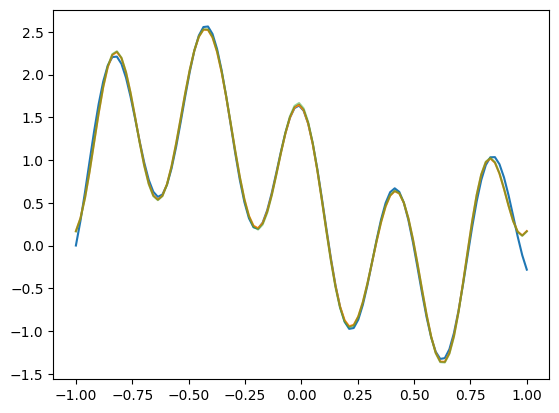

In [7]:
a_arr = a(t_grid, path, N)
b_arr = b(t_grid, path, N)
plt.plot(t_grid, path)
plt.plot(t_grid, recon_path)
plt.plot(t_grid, np.sum([a_arr[n]*np.cos(2*np.pi*n*t_grid/P)+
                         b_arr[n]*np.sin(2*np.pi*n*t_grid/P) for n in range(N+1)], axis=0), alpha=0.5)